# 丢弃法

理论上优于权重衰退

**动机**

- 好的模型应该对输入扰动鲁棒
    - 有噪音的数据，相当于`Tikhonov`正则，使得权重不要太大
    - 丢弃法：在层间加入噪音

******

**无偏差的加入噪声**

希望：$E[x'] = x$

$$x_i' = \begin{cases}0 & \text{with probability} p\\\frac{x_i}{1-p}&otherwise\end{cases}$$

******

**使用丢弃法**

- 通常作用在隐藏全连接层的输出上

$$
\begin{cases}
h=\sigma{W_1x+b_1} \\
h`= \text{dropout}(h) \\
o = W_2h`+b_2 \\
y = \text{softmax}(o)
\end{cases}
$$

> 训练中使用$dropout$，推理中不使用$dropout$

- 用于将隐藏层输出项随机设置为0来控制模型的复杂度
- 用于多层感知机(卷积神经网络一般不适用)
- 丢弃的概率是超参数

In [30]:
%matplotlib inline
import time
import os
import torch
import torchvision
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline

In [31]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1:
        return torch.zeros_like(X)
    elif dropout == 0:
        return X
    else:
        mask = torch.rand(X.shape) > float(dropout)
        # rand [0,1)的均匀分布，randn N(0, 1)分布
        # 这种写法对于 CPU GPU 均不是很好
        # 乘法优于选择
        # X[mask] = 0
        return mask * X / (1.0 - dropout)

x = torch.arange(1, 17, dtype=torch.float32).reshape((2, 8))
dropout_layer(x, 0.5) == 0

tensor([[ True, False,  True, False, False,  True,  True, False],
        [False, False,  True,  True,  True,  True,  True,  True]])

In [32]:
# 两个隐藏层的感知机
num_inputs, num_outputs, num_hidden1, num_hidden2 = 784, 512, 256, 10
dropout1 , dropout2 = 0.2, 0.5

class Net(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hidden1, num_hidden2, is_training=True):
        super().__init__()
        self.num_inputs = num_inputs
        self.training = is_training # 需要 is_training 判断是否 dropout

        self.lin1 = torch.nn.Linear(num_inputs, num_hidden1)
        self.lin2 = torch.nn.Linear(num_hidden1, num_hidden2)
        self.lin3 = torch.nn.Linear(num_hidden2, num_outputs)

        self.relu = torch.nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        if self.training:
            H1 = dropout_layer(H1, dropout=dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, dropout=dropout2)
        out = self.lin3(H2)
        return out

net = Net(num_inputs=num_inputs, num_outputs=num_outputs, num_hidden1=num_hidden1, num_hidden2=num_hidden2)

In [33]:
resize = None
num_cpu_cores = os.cpu_count()
trans = [torchvision.transforms.ToTensor()]
if resize:
    trans.insert(0, torchvision.transforms.Resize(resize))
trans = torchvision.transforms.ToTensor()
train_iter = torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=trans), batch_size, shuffle=True, num_workers=num_cpu_cores)
test_iter = torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=trans), batch_size, shuffle=True, num_workers=num_cpu_cores)

In [34]:
""" 累加器对象 """
class Accumulator: # 累加器对象
    """ 在 n 个变量上累加 """
    def __init__(self, n):
        self.data = [0.0] * n # python 语法 [0]*n将n个list连接在一起

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        # zip() 将迭代器打包成元组

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, index):
        return self.data[index]

""" 与真实值对比 """
def accuracy(y_hat, y):
    """ 分类问题，统计正确个数 """
    # y_hat 是二维矩阵，取每一行的最大值
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # 返回最大值对应的序号
    cmp = y_hat.type(y.dtype) == y # 保证 y 和 y_hat 类型相同
    # cmp 是 bool 类型
    return float(cmp.type(y.dtype).sum())

""" 评估 net 的准确性 """
def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval() # 如果是 torch 神经网络，则设置为评估模式，不进行反向传播
    accum = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            accum.add(accuracy(net(X), y), y.numel())
    return accum[0] / accum[1]

""" 一轮训练 """
def train_epoch_ch3(net, train_iter, loss, params, updater, lr):
    if isinstance(net, torch.nn.Module):
        net.train() # 训练模式，进行反向传播
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(params, lr, len(X)) # 更新器需要 batch_size
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]
""" 训练函数 """

def train_ch3(net, train_iter, test_iter, loss, num_epochs, params, updater, lr):
    accumulator = [Accumulator(3) for _ in range(num_epochs)]
    for epoch in range(num_epochs):
        start = time.perf_counter()
        train_metrics = train_epoch_ch3(net, train_iter, loss, params, updater, lr) # 训练误差
        test_accuracy = evaluate_accuracy(net, test_iter) # 测试误差
        accumulator[epoch].add(train_metrics[0], train_metrics[1], test_accuracy)
        end = time.perf_counter()
        print(f"Finish {epoch + 1} train, cose {end-start:.3f} sec")
    return accumulator

In [35]:
lr = 0.5
num_epochs=10
loss = torch.nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)
accumulator = train_ch3(net, train_iter, test_iter, loss, num_epochs, None, trainer, None)

Finish 1 train, cose 7.274 sec
Finish 2 train, cose 7.114 sec
Finish 3 train, cose 7.105 sec
Finish 4 train, cose 7.011 sec
Finish 5 train, cose 7.143 sec
Finish 6 train, cose 7.793 sec
Finish 7 train, cose 7.333 sec
Finish 8 train, cose 7.296 sec
Finish 9 train, cose 7.198 sec
Finish 10 train, cose 7.172 sec


Test accuracy : 0.828


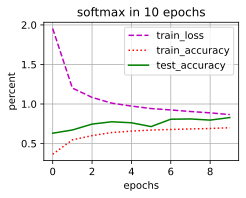

In [36]:
""" 打印图片 """
def show_img(imgs, num_rows, num_cols, title=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    plt.rcParams["figure.figsize"] = figsize
    for i in range(num_rows * num_cols):
        plt.subplot(num_rows, num_cols, i+1)
        plt.title(title[i])
        plt.axis('off')
        if torch.is_tensor(imgs[i].numpy()):
            plt.imshow(imgs[i].numpy())
        else:
            plt.imshow(imgs[i])

""" 绘图 """
backend_inline.set_matplotlib_formats('svg')
plt.rcParams["figure.figsize"] = (3.5, 2.5)

train_loss, train_accuracy, test_accuracy = [], [], []
for i in range(num_epochs):
    train_loss.append(accumulator[i][0])
    train_accuracy.append(accumulator[i][1])
    test_accuracy.append(accumulator[i][2])
    
plt.plot(list(range(num_epochs)), train_loss, 'm--')
plt.plot(list(range(num_epochs)), train_accuracy, 'r:')
plt.plot(list(range(num_epochs)), test_accuracy, 'g-')
plt.legend(["train_loss", "train_accuracy", "test_accuracy"])
plt.xlabel('epochs')
plt.ylabel('percent')
plt.title(f'softmax in {num_epochs} epochs')
plt.grid(True)

print(f"Test accuracy : {test_accuracy[-1]:.3f}")